<a href="https://colab.research.google.com/github/BigOyayubi/PyTorchTutorial/blob/master/PyTorch1_1_Image_01_TorchVisionTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://torch.classcat.com/2019/07/12/pytorch-1-1-tutorials-image-torchvision/

物体検出デモです。

少数の歩行者と歩行者位置矩形データセットを使って、事前訓練されたMask R-CNNモデルを再調整します。

Mask R-CNNはFaster R-CNNをベースとしており、Faster R-CNNの物体領域検出と物体クラス分類の機能に加えて、<br>
セグメンテーション（ピクセル単位で物体を識別）機能を有している。

Mask R-CNNについてはこちら＞https://qiita.com/shtamura/items/4283c851bc3d9721ed96

事前訓練データは大規模データセットCOCO train2017によるものです。

http://cocodataset.org/#home

![代替テキスト](http://torch.classcat.com/wp-content/uploads/2019/07/pytorch11-tutorials-torchvision-tv_demo.jpg)


In [29]:
#データセットのDL
!wget -nc https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip -o PennFudanPed.zip -d data
!ls -la data/PennFudanPed/

File ‘PennFudanPed.zip’ already there; not retrieving.

Archive:  PennFudanPed.zip
  inflating: data/PennFudanPed/added-object-list.txt  
  inflating: data/PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: data/PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: data/PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: data/PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: data/PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: data/PennFudanPed/Annotation/FudanPed00006.txt  
  inflating: data/PennFudanPed/Annotation/FudanPed00007.txt  
  inflating: data/PennFudanPed/Annotation/FudanPed00008.txt  
  inflating: data/PennFudanPed/Annotation/FudanPed00009.txt  
  inflating: data/PennFudanPed/Annotation/FudanPed00010.txt  
  inflating: data/PennFudanPed/Annotation/FudanPed00011.txt  
  inflating: data/PennFudanPed/Annotation/FudanPed00012.txt  
  inflating: data/PennFudanPed/Annotation/FudanPed00013.txt  
  inflating: data/PennFudanPed/Annotation/FudanPed00014.

In [30]:
#pycocotoolsを使うのでインストール
%%shell
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install

fatal: destination path 'cocoapi' already exists and is not an empty directory.
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
running install
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/coco.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/__init__.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/mask.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux

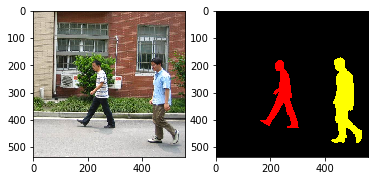

In [31]:
#画像を確認してみる
import matplotlib.pyplot as plt
import numpy as np

#PILは画像処理ライブラリ
from PIL import Image
img = Image.open('data/PennFudanPed/PNGImages/FudanPed00001.png')
plt.subplot(121)
plt.imshow(np.array(img))

mask = Image.open('data/PennFudanPed/PedMasks/FudanPed00001_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
plt.subplot(122)
plt.imshow(np.array(mask.convert('RGB')))
plt.show()

In [0]:
#Mask R-CNN向けにいい感じにデータを返すDatasetを作成する
import os
import numpy as np
import torch
from PIL import Image
 
class PennFudanDataset():
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
 
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
 
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
 
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
 
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
 
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
 
        if self.transforms is not None:
            img, target = self.transforms(img, target)
 
        return img, target
 
    def __len__(self):
        return len(self.imgs)

In [0]:
#Mask R-CNN構成２パタンの例示。後続では使わない
use_finetuning = True

if use_finetuning:
  #事前訓練済みモデルをFineTuningする
  import torchvision
  from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
  # 事前訓練済みモデルの読み込み
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # 分類器の置き換え
  num_classes = 2  # 1 class (person) + background
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one #predictor:予測子
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
else:
  #Faster R-CNNは
  # * Conv feature map(畳み込み特徴マップ。backbone)
  # * RoL(Region of Interest) feature vector(関心領域特徴ベクトル。rol_pooler)
  # からなり、それぞれに事前学習済みのNWを置き、事前計算済みMask R-CNNを構築する
  #バックボーンを置き換え
  import torchvision
  from torchvision.models.detection import FasterRCNN
  from torchvision.models.detection.rpn import AnchorGenerator
  # load a pre-trained model for classification and return
  # only the features
  backbone = torchvision.models.mobilenet_v2(pretrained=True).features
  # FasterRCNN needs to know the number of
  # output channels in a backbone. For mobilenet_v2, it's 1280
  # so we need to add it here
  backbone.out_channels = 1280
  # let's make the RPN generate 5 x 3 anchors per spatial
  # location, with 5 different sizes and 3 different aspect
  # ratios. We have a Tuple[Tuple[int]] because each feature
  # map could potentially have different sizes and
  # aspect ratios
  anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                        aspect_ratios=((0.5, 1.0, 2.0),))
  # let's define what are the feature maps that we will
  # use to perform the region of interest cropping, as well as
  # the size of the crop after rescaling.
  # if your backbone returns a Tensor, featmap_names is expected to
  # be [0]. More generally, the backbone should return an
  # OrderedDict[Tensor], and in featmap_names you can choose which
  # feature maps to use.
  roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)
  
  # put the pieces together inside a FasterRCNN model
  model = FasterRCNN(backbone,
                       num_classes=2,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler)

In [0]:
#FineTuningする用モデルを返す関数を用意
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
 
 
def get_model_instance_segmentation(num_classes):
  　　　#事前学習されたMasc R-CSNNをDL
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
 
    #分類数を取得
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #FineTuning用に予測器を事前学習済みのものから新しいものに差し替える
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
 
 　　　　　#マスク予測器の入力チャネル数を取得
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    #マスク予測器を事前学習済みのものから新しいものに差し替える
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
 
    return model

In [35]:
#いくつかヘルパ関数を使うため、ソースを取得する
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
#訓練と検証を行う関数を用意

from engine import train_one_epoch, evaluate
import utils
import transforms as T
 
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5)) #50%の確率で左右反転画像にする
    return T.Compose(transforms)

def exec():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print('device : %s' % device)
 
    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
    dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))
 
    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
 
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)
 
    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)
 
    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes)
 
    # move model to the right device
    model.to(device)
 
    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
 
    # let's train it for 10 epochs
    num_epochs = 10
 
    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)
 
    print("That's it!")
    return (dataset, dataset_test, model, device)

In [37]:
#実行

results = exec()

device : cuda
Epoch: [0]  [ 0/60]  eta: 0:02:00  lr: 0.000090  loss: 5.0048 (5.0048)  loss_classifier: 1.0905 (1.0905)  loss_box_reg: 0.1715 (0.1715)  loss_mask: 3.7151 (3.7151)  loss_objectness: 0.0051 (0.0051)  loss_rpn_box_reg: 0.0225 (0.0225)  time: 2.0126  data: 0.5420  max mem: 7388
Epoch: [0]  [10/60]  eta: 0:01:18  lr: 0.000936  loss: 1.9530 (2.6308)  loss_classifier: 0.6416 (0.6190)  loss_box_reg: 0.1789 (0.1910)  loss_mask: 1.0368 (1.7846)  loss_objectness: 0.0218 (0.0261)  loss_rpn_box_reg: 0.0082 (0.0101)  time: 1.5731  data: 0.0544  max mem: 7388
Epoch: [0]  [20/60]  eta: 0:01:01  lr: 0.001783  loss: 0.7632 (1.6653)  loss_classifier: 0.2164 (0.3966)  loss_box_reg: 0.1627 (0.1761)  loss_mask: 0.3290 (1.0615)  loss_objectness: 0.0146 (0.0202)  loss_rpn_box_reg: 0.0069 (0.0108)  time: 1.5079  data: 0.0069  max mem: 7388
Epoch: [0]  [30/60]  eta: 0:00:46  lr: 0.002629  loss: 0.5217 (1.2903)  loss_classifier: 0.0926 (0.2993)  loss_box_reg: 0.1497 (0.1665)  loss_mask: 0.2280 (0.

find 4 instances


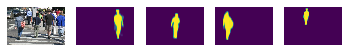

In [61]:
#学習結果に１枚データを入れて可視化して確認
# pick one image from the test set
 device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
 dset, dset_t, m, d = results
img, _ = dset_t[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = m([img.to(device)])
print('find %d instances' % prediction[0]['boxes'][0].size())

fig = plt.figure()
instance_num = len(prediction[0]['boxes'][0])

def clearLabel(_ax):
  _ax.set_xticks([])
  _ax.set_yticks([])
  _ax.set_xticklabels([])
  _ax.axis('off')
  return _ax

ax = fig.add_subplot(1,1+instance_num,1)
clearLabel(ax)
ax.imshow(img.permute(1,2,0).numpy())

for column in range(instance_num):
  ax = fig.add_subplot(1,1+instance_num,1+column+1)
  clearLabel(ax)
  ax.imshow(prediction[0]['masks'][column,0].mul(255).byte().cpu().numpy())

plt.show()